# Random Forest Classifier

## Pull and Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## NLP Cleaning

In [11]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christopherdelacruz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christopherdelacruz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
sw = stopwords.words('english')
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 
          'http', 'RT', '#','##','####','######','##########','##@user']
sw = sw + sw_add

In [15]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([@#a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [17]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]
test_token_docs = [doc_preparer(doc, sw) for doc in X_test]

## Pipeline on TFIDF on Random Forest Classifier

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [19]:
tfidf_rf_pipe = Pipeline([  
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('rf', RandomForestClassifier())
])

In [20]:
tfidf_rf_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('rf', RandomForestClassifier())])

In [21]:
tfidf_rf_pipe.score(token_docs, y_train)

0.9996562392574768

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
cross_val_score(tfidf_rf_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

array([0.55109961, 0.57271557, 0.59122085, 0.58831711, 0.57163324])

In [18]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [25]:
tfidf_rf_pipe.score(test_token_docs, y_test)

0.925531914893617

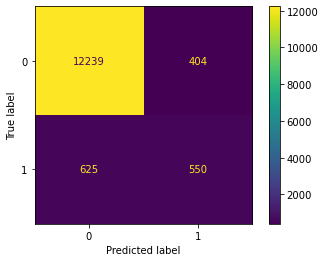

In [26]:
plot_confusion_matrix(tfidf_rf_pipe, test_token_docs, y_test)

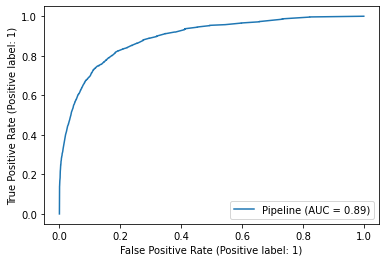

In [27]:
plot_roc_curve(tfidf_rf_pipe, test_token_docs, y_test)

In [28]:
y_hat = tfidf_rf_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12643
           1       0.58      0.47      0.52      1175

    accuracy                           0.93     13818
   macro avg       0.76      0.72      0.74     13818
weighted avg       0.92      0.93      0.92     13818



In [19]:
import numpy as np
tfidf_rf_params = {
    'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
    'SMOTE__sampling_strategy':['auto', .75, .9],
    'rf__n_estimators': [50, 1000],
    'rf__max_depth': [1, 5, 9]
}

In [20]:
from sklearn.model_selection import GridSearchCV

In [34]:
gs_tfidf_rf = GridSearchCV(tfidf_rf_pipe,
                            param_grid=tfidf_rf_params, 
                            cv = 3, 
                            verbose = 1,
                           n_jobs = -1)

In [35]:
gs_tfidf_rf.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'rf__max_depth': [1, 5, 9],
                         'rf__n_estimators': [50, 1000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=1)

In [36]:
gs_tfidf_rf.best_score_

0.9187096529352156

In [38]:
gs_tfidf_rf.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [39]:
gs_tfidf_rf.best_params_

{'SMOTE__sampling_strategy': 0.9,
 'rf__max_depth': 9,
 'rf__n_estimators': 1000,
 'tfidf__ngram_range': (1, 2)}

## Best Random Forest Model w/ TF-IDF

In [23]:
tfidf_best_rf_pipe = Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [24]:
tfidf_best_rf_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [25]:
cross_val_score(tfidf_best_rf_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

array([0.70625   , 0.69822485, 0.74358974, 0.77333333, 0.69852941])

In [44]:
tfidf_best_rf_pipe.score(token_docs, y_train)

0.9240288759023719

In [45]:
tfidf_best_rf_pipe.score(test_token_docs, y_test)

0.9218410768562745

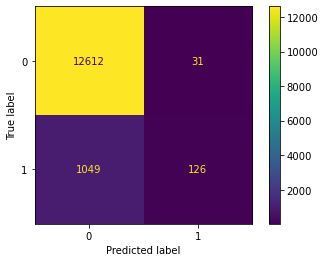

In [46]:
plot_confusion_matrix(tfidf_best_rf_pipe, test_token_docs, y_test)

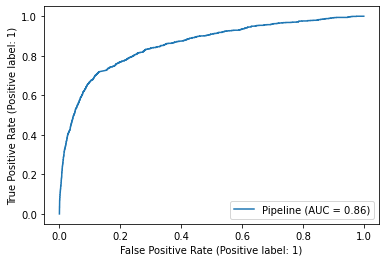

In [47]:
plot_roc_curve(tfidf_best_rf_pipe, test_token_docs, y_test)

In [48]:
y_hat_2 = tfidf_best_rf_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.80      0.11      0.19      1175

    accuracy                           0.92     13818
   macro avg       0.86      0.55      0.57     13818
weighted avg       0.91      0.92      0.89     13818



## Pipeline on Count Vectorizer on Random Forest Classifier

In [22]:
cv_rf_pipe = Pipeline([  
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('rf', RandomForestClassifier())
])

In [23]:
cv_rf_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('rf', RandomForestClassifier())])

In [21]:
cv_rf_params = {
    'cv__ngram_range':[(1,1), (1,2), (2,2)],
    'SMOTE__sampling_strategy':['auto', .75, .9],
    'rf__n_estimators': [50, 1000],
    'rf__max_depth': [1, 5, 9]
}

In [25]:
gs_cv_rf = GridSearchCV(cv_rf_pipe,
                            param_grid=cv_rf_params, 
                            cv = 3, 
                            verbose = 1,
                           n_jobs = -1)

In [26]:
gs_cv_rf.fit(token_docs, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'rf__max_depth': [1, 5, 9],
                         'rf__n_estimators': [50, 1000]},
             verbose=1)

In [27]:
gs_cv_rf.best_score_

0.9193247876978461

In [28]:
gs_cv_rf.best_estimator_

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [29]:
gs_cv_rf.best_params_

{'SMOTE__sampling_strategy': 0.9,
 'cv__ngram_range': (1, 1),
 'rf__max_depth': 9,
 'rf__n_estimators': 1000}

## Best Possible Random Forest Model with Count Vectorizer

In [26]:
cv_best_rf_pipe = Pipeline([  
    ('cv', CountVectorizer(ngram_range = (1,1))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('rf', RandomForestClassifier(max_depth = 9, n_estimators = 1000))
])

In [27]:
cv_best_rf_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [33]:
cv_best_rf_pipe.score(token_docs, y_train)

0.9218215700819598

In [28]:
cross_val_score(cv_best_rf_pipe, token_docs, y_train, scoring = 'precision', cv =5)

array([0.75609756, 0.66242038, 0.64925373, 0.72670807, 0.66666667])

In [34]:
cv_best_rf_pipe.score(test_token_docs, y_test)

0.9194528875379939

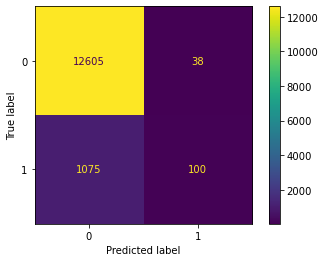

In [35]:
plot_confusion_matrix(cv_best_rf_pipe, test_token_docs, y_test)

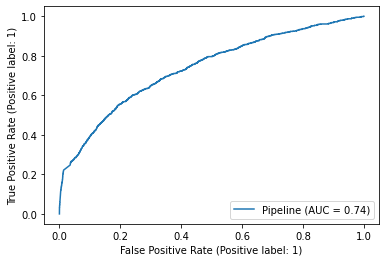

In [36]:
plot_roc_curve(cv_best_rf_pipe, test_token_docs, y_test)

In [37]:
y_hat_3 = cv_best_rf_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_3, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.72      0.09      0.15      1175

    accuracy                           0.92     13818
   macro avg       0.82      0.54      0.56     13818
weighted avg       0.90      0.92      0.89     13818



## NLP Cleanup with Only Words (no # or @)

In [29]:
def doc_preparer_2(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [30]:
token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_train]
test_token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_test]

## TFIDF / Random Forest / Pipeline Grid Search

In [24]:
tfidf_rf_pipe_2 = Pipeline([  
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('rf', RandomForestClassifier())
])

In [25]:
tfidf_rf_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('rf', RandomForestClassifier())])

In [26]:
gs_tfidf_rf_2 = GridSearchCV(tfidf_rf_pipe_2,
                            param_grid=tfidf_rf_params, 
                            cv = 3, 
                            verbose = 1,
                           n_jobs = -1)

In [27]:
gs_tfidf_rf_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'rf__max_depth': [1, 5, 9],
                         'rf__n_estimators': [50, 1000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=1)

In [28]:
gs_tfidf_rf_2.best_score_

0.9216587412323481

In [29]:
gs_tfidf_rf_2.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [30]:
gs_tfidf_rf_2.best_params_

{'SMOTE__sampling_strategy': 0.9,
 'rf__max_depth': 9,
 'rf__n_estimators': 1000,
 'tfidf__ngram_range': (1, 1)}

## Best Random Forest Model w/TFIDF

In [31]:
tfidf_best_rf_pipe_2 = Pipeline([  
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('rf', RandomForestClassifier(max_depth = 9, n_estimators = 1000))
])

In [32]:
tfidf_best_rf_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [33]:
tfidf_best_rf_pipe_2.score(token_docs_2, y_train)

0.924824953411373

In [33]:
cross_val_score(tfidf_best_rf_pipe_2, token_docs_2, y_train, scoring = 'precision', cv = 5)

array([0.56741573, 0.60736196, 0.60952381, 0.6466877 , 0.62006079])

In [35]:
tfidf_best_rf_pipe_2.score(test_token_docs_2, y_test)

0.9232160949486178

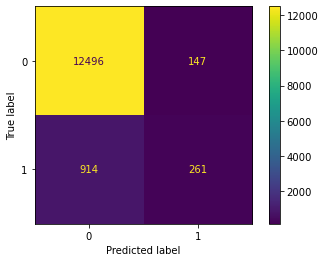

In [36]:
plot_confusion_matrix(tfidf_best_rf_pipe_2, test_token_docs_2, y_test)

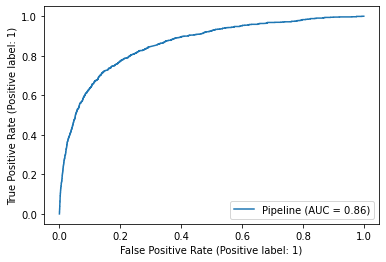

In [37]:
plot_roc_curve(tfidf_best_rf_pipe_2, test_token_docs_2, y_test)

In [38]:
y_hat_4 = tfidf_best_rf_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_4, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12643
           1       0.64      0.22      0.33      1175

    accuracy                           0.92     13818
   macro avg       0.79      0.61      0.64     13818
weighted avg       0.91      0.92      0.91     13818



## Pipeline Grid Search with Random Forest and Count Vectorizer

In [39]:
cv_rf_pipe_2 = Pipeline([  
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('rf', RandomForestClassifier())
])

In [40]:
cv_rf_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('rf', RandomForestClassifier())])

In [41]:
gs_cv_rf_2 = GridSearchCV(cv_rf_pipe_2,
                            param_grid=cv_rf_params, 
                            cv = 3, 
                            verbose = 1,
                           n_jobs = -1)

In [42]:
gs_cv_rf_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'rf__max_depth': [1, 5, 9],
                         'rf__n_estimators': [50, 1000]},
             verbose=1)

In [43]:
gs_cv_rf_2.best_score_

0.9204103499022076

In [44]:
gs_cv_rf_2.best_estimator_

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [45]:
gs_cv_rf_2.best_params_

{'SMOTE__sampling_strategy': 0.9,
 'cv__ngram_range': (1, 1),
 'rf__max_depth': 9,
 'rf__n_estimators': 1000}

## Best Random Forest Model for Count Vectorizer

In [34]:
cv_best_rf_pipe_2 = Pipeline([  
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('rf', RandomForestClassifier(max_depth = 9, n_estimators = 1000))
])

In [35]:
cv_best_rf_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('rf', RandomForestClassifier(max_depth=9, n_estimators=1000))])

In [48]:
cv_best_rf_pipe_2.score(token_docs_2, y_train)

0.9217311067286642

In [36]:
cross_val_score(cv_best_rf_pipe_2, token_docs_2, y_train, scoring = 'precision', cv = 5)

array([0.7414966 , 0.66857143, 0.64      , 0.73509934, 0.6969697 ])

In [50]:
cv_best_rf_pipe_2.score(test_token_docs_2, y_test)

0.9202489506440874

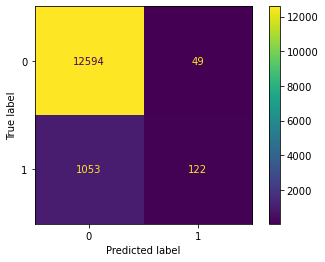

In [51]:
plot_confusion_matrix(cv_best_rf_pipe_2, test_token_docs_2, y_test)

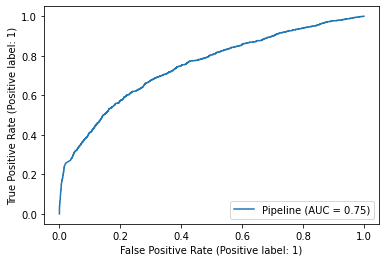

In [52]:
plot_roc_curve(cv_best_rf_pipe_2, test_token_docs_2, y_test)

In [53]:
y_hat_5 = cv_best_rf_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_5, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.71      0.10      0.18      1175

    accuracy                           0.92     13818
   macro avg       0.82      0.55      0.57     13818
weighted avg       0.91      0.92      0.89     13818

